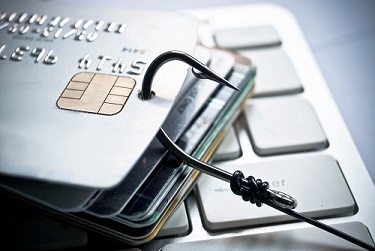

## Anomaly Detection Project - Clustering Aalysis  
### Last Updated: Nov 28th, 2021
------------  


<a id="I"></a>

## 1.  <span style="color:blue">Reading Data - Exploratory Data Analysis 

### Importing necessary Libraries 


In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()  #  Will import Seaborn functionalities

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report,accuracy_score
from sklearn.svm import OneClassSVM
from pylab import rcParams

# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings
warnings.filterwarnings('ignore')

### Read csv files 


#### Read both the files first ('tx_data.csv' and 'cc_info.csv')

In [2]:
anomaly_detection_1 = pd.read_csv('tx_data.csv', index_col=False) 
anomaly_detection_2 = pd.read_csv('cc_info.csv', index_col=False) 

#### Merge the two .csv files 

In [3]:
anomaly_detection_combined = pd.merge(anomaly_detection_2, anomaly_detection_1, 
                                      left_on='cc_number', right_on = 'cc_number', how = 'left' )

In [4]:
anomaly_detection_combined.head(5)

,user_id,zipcode,state,cc_number,cc_limit,date,transaction,long,lat
0,29421272,3280,NH,4983684529421272,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873
1,29421272,3280,NH,4983684529421272,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248
2,29421272,3280,NH,4983684529421272,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782
3,29421272,3280,NH,4983684529421272,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530
4,29421272,3280,NH,4983684529421272,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859


In [8]:
# anomaly_detection_combined.to_csv('anomaly_detection_combined.csv', index=False)

## 2: <span style="color:blue">Feature Selection</span>

Remove 'state' and 'cc_number' columns being redundant and not improtant

In [5]:
feat_sel = ['user_id', 'zipcode', 'cc_limit', 'date', 'transaction', 'long', 'lat']

anomaly_detection_combined = anomaly_detection_combined[feat_sel]

In [6]:
anomaly_detection_combined.head()

,user_id,zipcode,cc_limit,date,transaction,long,lat
0,29421272,3280,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873
1,29421272,3280,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248
2,29421272,3280,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782
3,29421272,3280,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530
4,29421272,3280,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859


Converting 'date' into datetime

In [7]:
#Below is the first part of the code
from datetime import datetime

# Converting 'date' from object to datetime type

anomaly_detection_combined['date']= pd.to_datetime(anomaly_detection_combined['date'], format= '%Y/%m/%d %H:%M:%S')

In [8]:
anomaly_detection_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233043 entries, 0 to 233042
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      233043 non-null  int64         
 1   zipcode      233043 non-null  int64         
 2   cc_limit     233043 non-null  int64         
 3   date         233043 non-null  datetime64[ns]
 4   transaction  233043 non-null  float64       
 5   long         233043 non-null  float64       
 6   lat          233043 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 14.2 MB


The `date` has been converted from "object" type to "datetime64" type

##  3. <span style="color:blue">Perform K-means Cluster Analysis</span>


### 3.1 Identifying Xs

In [12]:
# X = anomaly_detection_combined.iloc[:,[2,4,9]].values
X = anomaly_detection_combined.iloc[:,[2,4]].values

In [13]:
X

array([[1.000e+04, 4.465e+01],
       [1.000e+04, 5.680e+00],
       [1.000e+04, 6.319e+01],
       ...,
       [1.000e+04, 1.443e+01],
       [1.000e+04, 3.010e+01],
       [1.000e+04, 1.651e+01]])

In [14]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [16]:
scaled_features

array([[-0.55860769, -0.26885204],
       [-0.55860769, -0.58763985],
       [-0.55860769, -0.11718856],
       ...,
       [-0.55860769, -0.51606188],
       [-0.55860769, -0.38787597],
       [-0.55860769, -0.49904678]])

### 3.2  Data Scaling Data Preprocessing

In [17]:
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV

### 3.3. Choosing the Appropriate Number of Clusters

In this section, you’ll look at two methods that are commonly used to evaluate the appropriate number of clusters:  

    1- The elbow method  
    2- The silhouette coefficient 
    
These are often used as complementary evaluation techniques rather than one being preferred over the other. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE:

### 3.4 The Elbow method 

In [18]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
 "random_state": 42,
 }

In [19]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

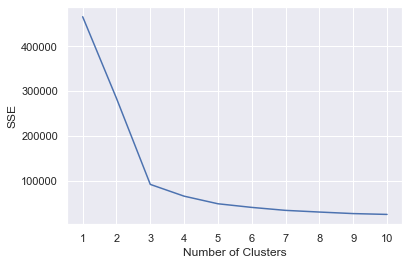

In [20]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### 3.5 The Silhouette Coefficient 

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

__How close the data point is to other points in the cluster__  
__How far away the data point is from points in other clusters__ 

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

In the scikit-learn implementation of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score. The silhouette score() function needs a minimum of two clusters, or it will raise an exception.

Loop through values of k again. This time, instead of computing SSE, compute the silhouette coefficient:

In [ ]:
# from sklearn.metrics import silhouette_score

# # A list holds the silhouette coefficients for each k
# silhouette_coefficients = []

# # Notice you start at 2 clusters for silhouette coefficient
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(scaled_features)
#     score = silhouette_score(scaled_features, kmeans.labels_)
#     silhouette_coefficients.append(score)

### 3.6  Building Model ( K-Means )

In [21]:
# Create the model

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 45)

In [22]:
sscaler = StandardScaler()

In [23]:
cluster_pipe = Pipeline([('scaler', sscaler), ('kmeans', kmeans)])

In [24]:
# Fitting K-Means to the dataset
cluster_pipe = kmeans.fit_predict(X)

In [25]:
# Read the predicted cluster
cluster_pipe

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
# Here is the code for getting the labels property of the K-means clustering example dataset; that is, how the data points are 
# categorized into  clusters.

kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
#kmeans = KMeans()
kmeans_2C = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)
#sscaler = StandardScaler()

In [28]:
cluster_pipe = Pipeline([('scaler', sscaler), ('kmeans', kmeans_2C)])

In [29]:
cluster_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=123))])

In [30]:
cluster_pipe.named_steps

{'scaler': StandardScaler(), 'kmeans': KMeans(n_clusters=3, random_state=123)}

In [31]:
res = cluster_pipe.named_steps['kmeans']
res

KMeans(n_clusters=3, random_state=123)

In [32]:
res.labels_

array([0, 0, 0, ..., 0, 0, 0])

###  3.7  Visualising the clusters

In [33]:
# The lowest SSE value
kmeans.inertia_

746498414755.3732

In [34]:
# The number of iterations required to converge
kmeans.n_iter_

2

In [35]:
# Here is the result of the value of the centroids:
kmeans.cluster_centers_

array([[19457.3246692 ,    93.83462055],
       [ 7980.85663132,    64.43295099],
       [14116.50714712,    82.52385931]])

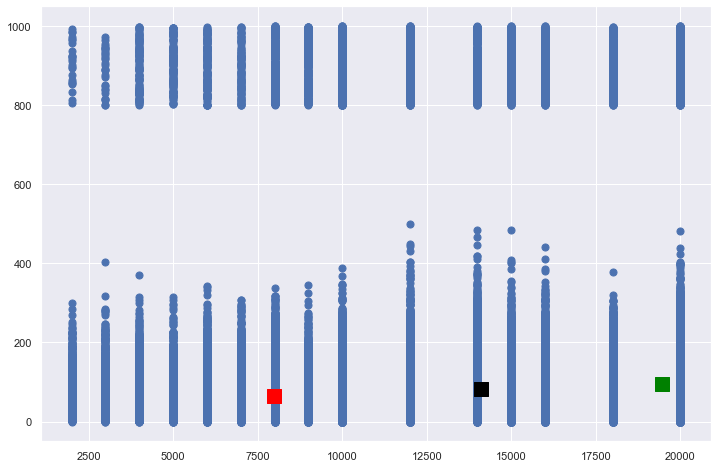

In [36]:
# Let’s display the cluster centroids (using green and red color).
plt.rcParams['figure.figsize'] = 12,8

plt.scatter(X[ : , 0], X[ : , 1], s = 50, c ='b')
plt.scatter(19457.3246692 , 93.83462055, s =200, c ='green',  marker   ='s', label = 'Cluster 0')
plt.scatter(7980.85663132,  64.43295099, s =200, c ='red',    marker   ='s', label = 'Cluster 1')
plt.scatter(14116.50714712,    82.52385931, s =200, c ='black',  marker   ='s', label = 'Cluster 2')
#plt.scatter(26.30434783, 20.91304348, s =200, c ='orange', marker   ='s', label = 'Cluster 3')
# plt.scatter(25.72727273, 79.36363636, s =200, c ='purple', marker   ='s', label = 'LH Clients')
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')

# plt.title('Clusters of customers')
# plt.xlabel('Annual Income (k$)')
# plt.ylabel('Spending Score (1-100)')
# plt.legend()
# plt.show()

### 3.8  Labeling Data

In [37]:
# Adding Cluster columns to Dataset 
anomaly_detection_combined['clusters'] = res.labels_

In [38]:
anomaly_detection_combined.head(20)

,user_id,zipcode,cc_limit,date,transaction,long,lat,clusters
0,29421272,3280,10000,2016-08-11 19:14:06,44.65,-72.174098,43.156873,0
1,29421272,3280,10000,2016-06-10 22:09:53,5.68,-72.131747,43.213248,0
2,29421272,3280,10000,2016-07-27 04:18:40,63.19,-72.022366,43.161782,0
3,29421272,3280,10000,2016-05-27 00:39:42,122.04,-72.159013,43.235530,0
4,29421272,3280,10000,2016-08-15 22:14:28,53.66,-72.169355,43.170859,0
5,29421272,3280,10000,2016-08-12 19:17:18,94.63,-72.093989,43.211544,0
6,29421272,3280,10000,2016-08-10 23:36:35,204.67,-72.159371,43.174119,0
7,29421272,3280,10000,2016-07-05 19:47:25,71.91,-72.102385,43.190865,0
8,29421272,3280,10000,2016-06-30 01:30:15,141.12,34.937667,47.299042,0
9,29421272,3280,10000,2016-08-12 00:54:14,123.12,-72.092823,43.173522,0


In [39]:
table = pd.pivot_table(data=anomaly_detection_combined,index=['clusters'])

In [40]:
table

,cc_limit,lat,long,transaction,user_id,zipcode
clusters,,,,,,
0,8715.491136,41.162118,-76.380257,51.781103,5.153817e+07,18476.743236
1,17481.608710,40.637553,-76.611259,73.773029,4.962728e+07,18323.074476
2,12942.022263,40.765446,-76.393661,899.212217,5.082720e+07,18751.697356
